# Tiling images with overlap
When processing images in tiles, we can observe artifacts on borders of the tiles in the resulting image. One strategy to prevent these artifacts is to process tiles with some overlap. [dask](https://docs.dask.org/en/stable/) also supports this. Again, for demonstration purposes, we use `imshow` to show the resulting images. If these were big data, the `imshow` function would not work.

In [1]:
import dask
import dask.array as da
from skimage.filters import gaussian
from skimage.data import cells3d
from stackview import imshow

Similar to the example in the last lesson, we define a procedure that applies a Gaussian blur to an image and prints out the size of the image, just so that we know:

In [2]:
def procedure(image):
    print("processing", image.shape)
    return gaussian(image, sigma=5)

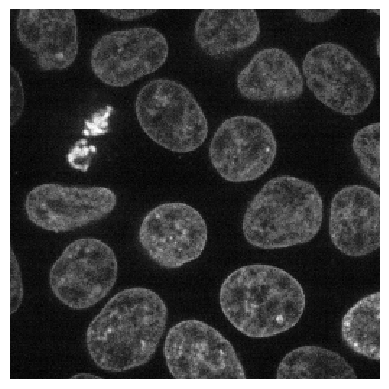

In [3]:
image = cells3d()[30,1]
imshow(image)

After loading the image, we tile it as usual.

In [4]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

Next, we tell dask what to do with our tiles: We want to map the function `procedure` to the tiles with a [defined overlap](https://docs.dask.org/en/stable/generated/dask.array.map_overlap.html#dask.array.map_overlap).

In [5]:
overlap_width = 1
tile_map = da.map_overlap(procedure, tiles, depth=overlap_width)

proceduring (0, 0)
proceduring (1, 1)


The function was executed twice with very small images (0x0 and 1x1 pixels) to check if it works. Next, we actually compute the result.

In [6]:
result = tile_map.compute() # Warning: This loads all image data into memory

proceduring (129, 129)
proceduring (129, 129)
proceduring (129, 129)
proceduring (129, 129)
proceduring (128, 128)
proceduring (128, 128)
proceduring (128, 128)
proceduring (128, 128)
proceduring (138, 138)
proceduring (138, 138)
proceduring (168, 168)
proceduring (168, 168)


From the printed image size, we can see that the processed image size is 2 pixels larger than the tile size. That's the overlap of 1 pixel in all directions. 

## Minimizing border effects
Next, we will compare the result when processing the whole image with the image processed in tiles with different overlaps. This gives us the chance to figure out the minimum necessary overlap width for eliminating border effects. First, we compute the result for the full image.

In [7]:
untiled_result = procedure(image)

proceduring (256, 256)


Then, we run a for-loop with different `border_width`s.

Overlap width 0
proceduring (0, 0)
proceduring (1, 1)


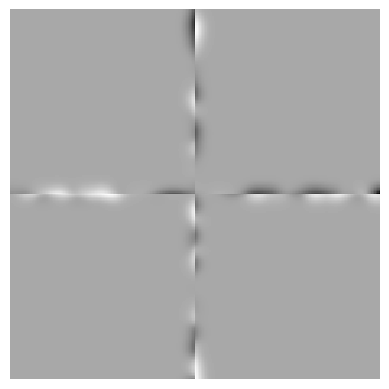

sum difference 1.528818863147824
-----------------------------------
Overlap width 5
proceduring (0, 0)
proceduring (1, 1)
proceduring (138, 138)
proceduring (138, 138)


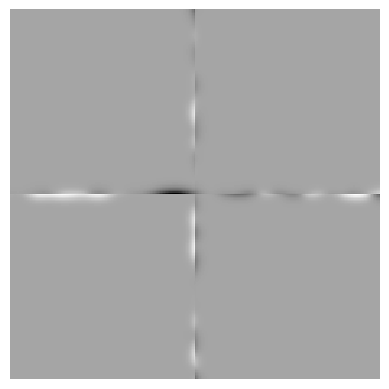

sum difference 2.098167990865754
-----------------------------------
Overlap width 10
proceduring (0, 0)
proceduring (1, 1)
proceduring (148, 148)
proceduring (148, 148)
proceduring (148, 148)
proceduring (148, 148)


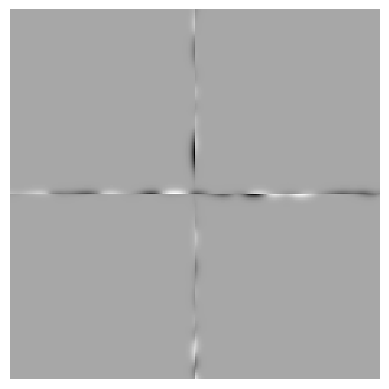

sum difference -0.18132395183423158
-----------------------------------
Overlap width 15
proceduring (0, 0)
proceduring (1, 1)
proceduring (158, 158)
proceduring (158, 158)
proceduring (158, 158)
proceduring (158, 158)


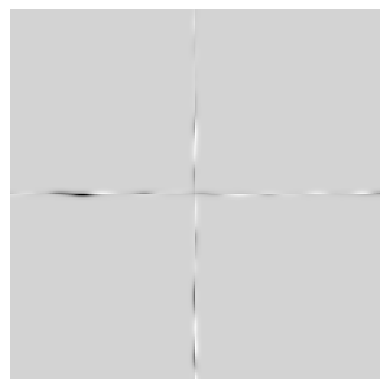

sum difference -0.005761703866654207
-----------------------------------
Overlap width 20
proceduring (0, 0)
proceduring (1, 1)
proceduring (168, 168)
proceduring (168, 168)


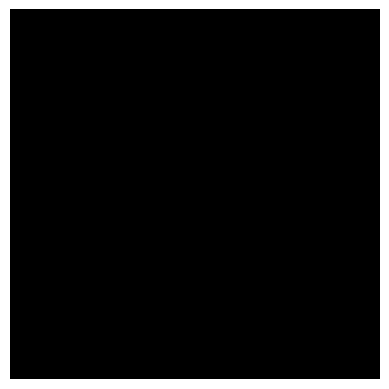

sum difference 0.0
-----------------------------------


In [8]:
for overlap_width in range(0, 25, 5):
    print("Overlap width", overlap_width)
    tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary='nearest')
    result = tile_map.compute()
    difference = result - untiled_result
    imshow(difference)
    print("sum difference", difference.sum())
    print("-----------------------------------")

As you can see, for completely eliminating the border effect, we need to use an overlap of 25 pixels. This is obviously related to the `procedure` we applied. In our case, the Gaussian blur used in `procedure` was configured with `sigma=5`. As a rule of thumb we can say that in the case of a Gaussian blur, the border width must be at least four times the configured sigma. However, when using more complicated algorithms, there are no such rules. In general, it is recommended to test tiled image processing on small images as demonstrated here and figure out if artifacts appear and what error they may cause in a longer image processing workflow.

## Exercise
Apply a top-hat background removal filter with radius 6 to the image and determind the overlap width you need to apply for artifact-free images.